In [449]:
from SimPEG import Mesh, Utils, EM, Maps
from pymatsolver import Pardiso
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt
from TDEM import ProblemSkyTEM
%matplotlib inline

In [455]:
sigma_background = 1./20.
sigma_target = 1./10.
resistivity_background = 1./sigma_background
resistivity_target = 1./sigma_target
resistivity = np.array([resistivity_background, resistivity_target, resistivity_background], dtype=float)
thickness = np.array([50, 40], dtype=float)
source_area = 536.36
data_dir = "/Users/sgkang/Dropbox/Stanford/Resolution/aarhusinv/em1dinv_examples/notebooks/"
waveform_hm = np.loadtxt(data_dir+"HM_butte_304.txt")
time_gates_hm = np.loadtxt(data_dir+"HM_butte_304_gates")[7:,:] * 1e-6
waveform_lm = np.loadtxt(data_dir+"LM_butte_304.txt")
time_gates_lm = np.loadtxt(data_dir+"LM_butte_304_gates")[8:,:] * 1e-6

time_input_currents_HM = waveform_hm[:,0]
input_currents_HM = waveform_hm[:,1]
time_input_currents_LM = waveform_lm[:,0]
input_currents_LM = waveform_lm[:,1]
    
time_LM = time_gates_lm[:,3] - waveform_lm[:,0].max()
time_HM = time_gates_hm[:,3] - waveform_hm[:,0].max()
source_area = 536.36

In [456]:
from discretize import utils
rxloc = np.array([13.25, 0., 30.+2.])
srcloc = np.array([0., 0., 30.])
xyz = np.vstack((rxloc, srcloc))
x = np.linspace(-1200., 1200.)
y = np.linspace(-50., 50.)
dem = Utils.ndgrid(x,y,np.r_[0.])
h = [10., 10., 5.]
mesh_global = utils.mesh_builder_xyz(
    dem,
    h,
    padding_distance=[[2000., 2000.], [1000, 1000], [2000., 0.]],
    base_mesh=None,
    depth_core=None,
    expansion_factor=1.3,
    mesh_type='tree'
)

mesh_global = utils.refine_tree_xyz(
    mesh_global,
    dem,
    method='surface',
    octree_levels=[4, 5, 5],
    octree_levels_padding=None,
    finalize=False,
    min_level=0,
    max_distance=np.inf,    
)

x = np.linspace(-2000., 2000.)
y = np.linspace(-50., 50.)
dem = Utils.ndgrid(x,y,np.r_[0.])


mesh_global = utils.refine_tree_xyz(
    mesh_global,
    dem,
    method='surface',
    octree_levels=[0, 1, 1],
    octree_levels_padding=None,
    finalize=True,
    min_level=0,
    max_distance=np.inf,    
)

In [461]:
x = np.arange(21)*100 - 1000.
y = np.r_[0.]
z = np.r_[30.]
srclocs = Utils.ndgrid(x, y, z)
rxlocs = Utils.ndgrid(x-13.25, y, z+2.)
n_src = srclocs.shape[0]

(-300, 0)

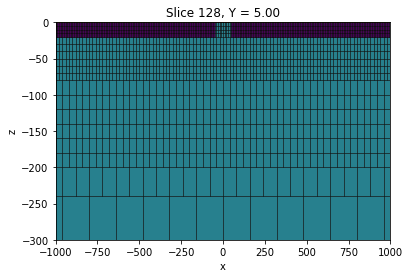

In [533]:
# mesh_global.plotSlice(np.log10(1./sigma), normal='X', grid=True, clim=(np.log10(10), np.log10(50)))
# plt.plot(srclocs[:,0], srclocs[:,2], 'r.')
# plt.xlim(-2000, 2000)
# plt.ylim(-300, 100)
# # plt.gca().set_aspect(5)

In [534]:
# mesh_global.plotSlice(np.log10(1./sigma), normal='z', grid=True, clim=(np.log10(10), np.log10(50)), ind=255)
# plt.plot(srclocs[:,0], srclocs[:,1], 'r.')
# plt.xlim(-200, 200)
# plt.ylim(-200, 200)
# # plt.gca().set_aspect(5)

In [518]:
rxloc = np.array([13.25, 0., 30.+2.])
srcloc = np.array([0., 0., 30.])

def create_local_problem(srcloc, rxloc, mesh_global, actv_global):
    xyz = np.vstack((rxloc, srcloc))
    print (srcloc[0], srcloc[1])
    x = np.linspace(-100., 100.) + srcloc[0]
    y = np.linspace(-20., 20.) + srcloc[1]
    dem = Utils.ndgrid(x,y,np.r_[0.])
    h = [10., 10., 5.]
    mesh_local = utils.mesh_builder_xyz(
        dem,
        h,
        padding_distance=[[2000., 2000.], [2000., 2000.], [2000., 2000.]],
        base_mesh=None,
        depth_core=None,
        expansion_factor=1.3,
        mesh_type='tree'
    )

    mesh_local = utils.refine_tree_xyz(
        mesh_local,
        dem,
        method='surface',
        octree_levels=[1, 0, 5],
        octree_levels_padding=None,
        finalize=False,
        min_level=0,
        max_distance=np.inf,    
    )


    mesh_local = utils.refine_tree_xyz(
        mesh_local,
        xyz,
        method='radial',
        octree_levels=[2, 0, 0],
        octree_levels_padding=None,
        finalize=True,
        min_level=1,
        max_distance=np.inf,    
    )
    # Assume flat topo
    actv_local = mesh_local.gridCC[:,2]<0.
    tile_map = Maps.Tile((mesh_global, actv_global), (mesh_local, actv_local))    
    act_map = Maps.InjectActiveCells(mesh_local, tile_map.activeLocal, valInactive=1e-8)
    mapping = act_map * tile_map 
    rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
    # src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
    src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
    survey = EM.TDEM.Survey([src])
    prb = ProblemSkyTEM(mesh_local, sigmaMap=mapping, verbose=False)
    dts = np.diff(np.logspace(-6, -1, 50))
    prb.timeSteps = [(3e-7, 6),(1e-6, 5),(2e-6, 5),(5e-6, 5),(1e-5, 5),(2e-5, 5),(5e-5, 5),(1e-4, 5),(2e-4, 5),(5e-4, 5),(1e-3, 15)]
    prb.Solver = Pardiso
    prb.pair(survey)    
    return prb
#     return mesh_local, sigma_local
    

In [519]:
# i_src=9
# mesh_local, sigma_local = create_local_problem(srclocs[i_src,:], rxlocs[i_src,:], mesh_global, actv_global)
# mesh_local.plotSlice(sigma_local, normal='Y', grid=True)
# plt.xlim(-1000, 1000)
# plt.ylim(-200, 100)
# plt.gca().set_aspect(5)

In [520]:
# i_src=11
# mesh_local, sigma_local = create_local_problem(srclocs[i_src,:], rxlocs[i_src,:], mesh_global, actv_global)
# mesh_local.plotSlice(sigma_local, normal='Y', grid=True)
# plt.xlim(-1000, 1000)
# plt.ylim(-200, 100)
# plt.gca().set_aspect(5)

In [521]:
prbs = []
for ii in range(n_src):
    prbs.append(create_local_problem(srclocs[ii,:], rxlocs[ii,:], mesh_global, actv_global))

-1000.0 0.0
-900.0 0.0
-800.0 0.0
-700.0 0.0
-600.0 0.0
-500.0 0.0
-400.0 0.0
-300.0 0.0
-200.0 0.0
-100.0 0.0
0.0 0.0
100.0 0.0
200.0 0.0
300.0 0.0
400.0 0.0
500.0 0.0
600.0 0.0
700.0 0.0
800.0 0.0
900.0 0.0
1000.0 0.0


In [742]:
sigmas = []
ls = [20, 40, 80, 160, 240, 320]
for l in ls:
    sigma = np.ones(mesh_global.nC) * 1e-8
    actv_global = mesh_global.gridCC[:,2]<0.
    sigma[actv_global] = sigma_background
    z = 50.
    h = 20
#     l = 400
    inds = np.logical_and(mesh_global.gridCC[:,2]<-(z), mesh_global.gridCC[:,2]>-(z+h))
    sigma[inds] = sigma_target
    inds_gap = np.logical_and(mesh_global.gridCC[:,0]<l/2, mesh_global.gridCC[:,0]>-l/2) & inds
    sigma[inds_gap] = sigma_background
    sigma[~actv_global] = 1e-8
    sigmas.append(sigma)

In [743]:
import matplotlib
matplotlib.rcParams['font.size'] = 14

Text(0, 0.5, 'z (m)')

<Figure size 720x360 with 0 Axes>

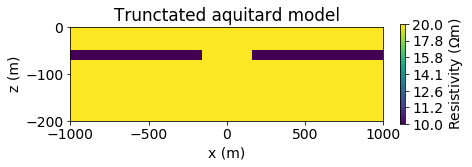

In [748]:
ii = 5
fig = plt.figure(figsize=(10, 5))
out = mesh_global.plotSlice(np.log10(1./sigmas[ii]), normal='Y', grid=False, clim=(np.log10(10), np.log10(20)))
plt.plot(srclocs[:,0], srclocs[:,2], 'r.')
plt.xlim(-1000, 1000)
plt.ylim(-200, 0)
plt.gca().set_aspect(3)
cb = plt.colorbar(out[0], fraction=0.015)
cb.set_ticks(cb.get_ticks())
cb.set_ticklabels([("%.1f")%(10**x)for x in cb.get_ticks()])
cb.set_label("Resistivity ($\Omega$m)")
plt.title("Trunctated aquitard model")
plt.xlabel('x (m)')
plt.ylabel('z (m)')

In [ ]:
# mesh_global.writeVTK('test', models={'sigma':sigma})

In [701]:
# rx = EM.TDEM.Rx.Point_dbdt(rxloc, np.logspace(np.log10(1e-6), np.log10(1e-2), 31), 'z')
# # src = EM.TDEM.Src.CircularLoop([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc, radius=13.)
# src = EM.TDEM.Src.MagDipole([rx], waveform=EM.TDEM.Src.StepOffWaveform(), loc=srcloc)
# survey = EM.TDEM.Survey([src])
# prb = ProblemSkyTEM(mesh_local, sigma=sigma_local, verbose=False)
# dts = np.diff(np.logspace(-6, -1, 50))
# prb.timeSteps = [(3e-7, 6),(1e-6, 5),(2e-6, 5),(5e-6, 5),(1e-5, 5),(2e-5, 5),(5e-5, 5),(1e-4, 5),(2e-4, 5),(5e-4, 5),(1e-3, 15)]
# prb.Solver = Pardiso
# prb.pair(survey)    

# data_hm_0, data_lm_0 = prb.simulate(
# [],
# time_HM,
# time_LM,
# time_input_currents_HM, 
# input_currents_HM,
# time_input_currents_LM, 
# input_currents_LM,    
# )


In [683]:
# %%time
data_hms = []
data_lms = []

for sigma in sigmas:
    temp_hms = np.zeros((len(prbs), time_HM.size), dtype=float)
    temp_lms = np.zeros((len(prbs), time_LM.size), dtype=float)    
    for ii, prb in enumerate(prbs):
        data_hm, data_lm = prb.simulate(
        sigma[prb.sigmaMap.maps[1].actvGlobal],
        time_HM,
        time_LM,
        time_input_currents_HM, 
        input_currents_HM,
        time_input_currents_LM, 
        input_currents_LM,    
        )
        temp_hms[ii,:] = data_hm
        temp_lms[ii,:] = data_lm
    data_hms.append(temp_hms)    
    data_lms.append(temp_lms)    

In [786]:
# Generate layered earth data
data_lms_0 = np.tile(data_lms[0][0,:], (21, 1))
data_hms_0 = np.tile(data_hms[0][0,:], (21, 1))
# data_lms_0 += abs(data_lms_0)*0.03*np.random.randn(data_lms_0.shape[0], data_lms_0.shape[1])
# data_hms_0 += abs(data_hms_0)*0.03*np.random.randn(data_hms_0.shape[0], data_hms_0.shape[1])

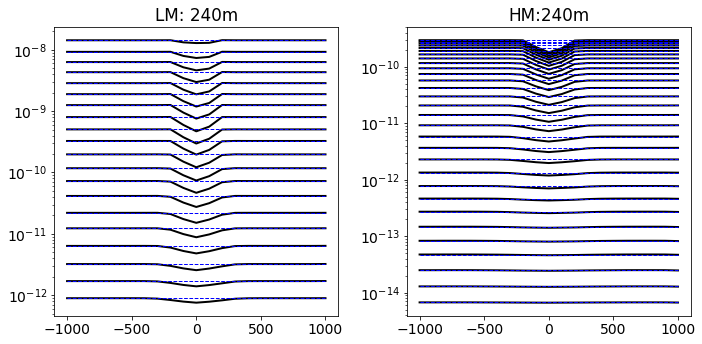

In [787]:
ii=4
titles = ['LM: '+ str(ls[ii]) + 'm', 'HM:' + str(ls[ii]) + 'm']
fig, axs = plt.subplots(1,2, figsize = (10, 5))
out = axs[0].semilogy(srclocs[:,0], -np.vstack(data_lms[ii]), 'k-', lw=2)
out = axs[0].semilogy(srclocs[:,0], -np.vstack(data_lms_0), 'b--', lw=1)
out = axs[1].semilogy(srclocs[:,0], -np.vstack(data_hms[ii]), 'k-', lw=2)
out = axs[1].semilogy(srclocs[:,0], -np.vstack(data_hms_0), 'b--', lw=1)
for i_ax, ax in enumerate(axs):
    ax.set_title(titles[i_ax])
plt.tight_layout()

[Text(1, 0, '5%')]

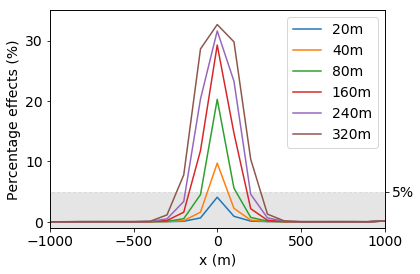

In [788]:
rerrs = np.zeros((len(sigma), 21), dtype=float)
labels = [str(l) + 'm' for l in ls]
for ii in range(len(sigmas)):
    rerr_lm = np.sqrt((((data_lms[ii]-data_lms_0) / data_lms_0)**2).sum(axis=1) / time_LM.size) * 100
    plt.plot(srclocs[:,0], rerr_lm, '-', ms=3)
plt.legend(labels)
plt.fill_between(srclocs[:,0], np.ones(21)*5., y2=np.ones(21)*-1., color='grey', alpha=0.2, linestyle='--')
plt.xlim(-1000, 1000)
plt.ylim(-1, 35)
plt.xlabel("x (m)")
plt.ylabel("Percentage effects (%)")
ax = plt.gca().twinx()
ax.set_ylim(-1, 35)
ax.set_yticks([5.])
ax.set_yticklabels(["5%"])

In [789]:
data_lm = data_lms[0][10,:]
data_hm = data_hms[0][10,:]

In [790]:
# mesh_local.plotSlice(sigma_local, normal='Y')

In [791]:
from simpegEM1D import EM1D, EM1DSurveyTD, Utils1D, get_vertical_discretization_time, set_mesh_1d, piecewise_pulse
from SimPEG import Maps
def simulation(src_type, n_pulse=1, use_lowpass_filter=True):
    hz = np.r_[thickness.copy(), 1e3]
    mesh1D = set_mesh_1d(hz)
    depth = -mesh1D.gridN[:-1]

    if src_type == "CircularLoop":
        # Effective radius
        radius = np.sqrt(source_area/np.pi)        
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'CircularLoop',    
            I = 1,    
            a = radius,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 30.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    elif src_type == "VMD":
        TDsurvey = EM1DSurveyTD(
            rx_location = np.array([0., 0., 100.+30.+2.]),
            src_location = np.array([0., 0., 100.+30.]),
            topo = np.r_[0., 0., 100.],
            depth = depth,
            rx_type = 'dBzdt',
            wave_type = 'general',
            src_type = 'VMD',    
            offset=np.array([13.25]),
            I = 1.,
            time = time_HM,
            time_input_currents=time_input_currents_HM,
            input_currents=input_currents_HM,
            n_pulse = n_pulse,
            base_frequency = 30.,
            use_lowpass_filter=use_lowpass_filter,
            high_cut_frequency=210*1e3,
            moment_type='dual',
            time_dual_moment = time_LM,    
            time_input_currents_dual_moment=time_input_currents_LM,
            input_currents_dual_moment=input_currents_LM,
            base_frequency_dual_moment=210,    
        )
    chi_half = 0.
    expmap = Maps.ExpMap(mesh1D)

    prob = EM1D(mesh1D, sigmaMap=expmap, verbose=False)
    m_true = np.log(1./resistivity)
    if prob.ispaired:
        prob.unpair()
    if TDsurvey.ispaired:
        TDsurvey.unpair()
    prob.pair(TDsurvey)
    prob.chi = np.zeros(TDsurvey.n_layer)
    d_true = -TDsurvey.dpred(m_true)
    return d_true

ValueError: x and y must have same first dimension, but have shapes (20,) and (420,)

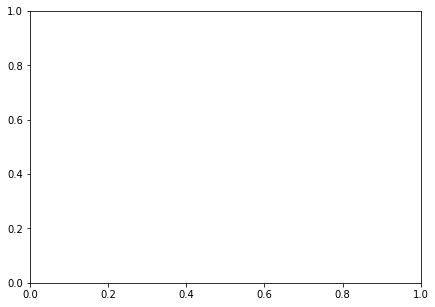

In [605]:
d_true = simulation('VMD', use_lowpass_filter=False, n_pulse=1)
n_time = time_HM.size
fig, axes = plt.subplots(1,1, figsize = (7,5))
# axes.plot(time_gates_lm[:,3], d_true[n_time:], 'b-')
# axes.plot(time_gates_hm[:,3], d_true[:n_time], 'k-')
axes.plot(time_gates_lm[:,3], -data_lms[0].flatten(), 'b-')
axes.plot(time_gates_hm[:,3], -data_hms[0].flatten(), 'k-')

axes.plot(time_gates_lm[:,3], -data_lm.flatten(), 'b--')
axes.plot(time_gates_hm[:,3], -data_hm.flatten(), 'k--')
axes.set_xscale('log');
axes.set_yscale('log');
plt.legend(("Aarhus1D-LM", "Aarhus1D-HM", "simpeg-LM", "simpeg-HM"))
axes.set_xlabel("Time (ms)")
axes.set_ylabel("Voltage (V/A)")

In [ ]:
plt.semilogx(time_gates_lm[:,3], abs((data_lm.flatten()-data_lms[0].flatten()) / data_lm.flatten()))
plt.semilogx(time_gates_hm[:,3], abs((data_hm.flatten()-data_hms[0].flatten()) / data_hm.flatten()))